<h4>Introduction</h4>
<p>A sawmill is a very linear process with a series of machines sequentially turning a timber log into an array of marketable boards. Because the process is linear and sequential, problems or quality issues at an early machine in the process can lead to even bigger issues at a later machine. For this study, I would like to examine an issue that has occurred at a sawmill, where the partially sawn log ("cant") being fed into one machine is skewing excessively and causing machine set and board quality issues. To perform this study, I have pulled machine runtime data from two machine centers in the sawmill. The first machine is a primary breakdown machine that takes in a log and creates two flat faces (a cant) by sawing two boards off. The second machine is a gang saw that takes the cant and cuts it into multiple boards. The cant is tracked from one machine to the next, and the data is joined. The following data set contains information on 272,008 logs that were run through these machines in the period between May and November of 2024. </p>
<p>The goal of this study is to create a classification model that can correctly categorize whether a cant will be highly skewed or not and give some insight into why cants are skewing in general. To accomplish this goal, I will examine the metrics for a decision tree, random forest, and support vector machine. The final model will be the best performing on the basis of reasonable metrics and good cpu performance.  <p/>

In [2]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("gang_sc_data_afterMay.csv")

<h4>Data Cleaning</h4>
The dataset contains a lot of extraneous ID and timestamp columns that will be removed. Initially, all ID and timestamp columns will be removed and all log diameter sizing variables except one.

In [4]:
df.head()
df = df.drop(['sharpchain_key', 
              'time', 
              'prev1sed', 
              'prev2sed', 
              'logid', 
              'shp_no_plc', 
              'gang_uid-2',
              'time_end', 
              'turning_distance', 
              'gang_cycle_time_id_ptr', 
              'gangid', 
              'diameter_class',
              'class_order', 
              'inch_class', 
              'sc_uid', 
              'at_gang_time', 
              'gang_id', 
              'sharpchain_id', 
              'id',
              'sc_uid-2', 
              'gang_uid', 
              'time-2', 
              'gang_key', 
              'accumulated_dt-2', 
              'gang_id-2', 
              'length-2',
              'in_time', 
              'shape_number',
              'gang_rate', 
              'face_offset', 
              'left_opening_face', 
              'right_opening_face'], axis = 1)

In [5]:
df['local_time'] = pd.to_datetime(df['local_time'])
df['hour'] = df['local_time'].dt.hour

There are also some columns that are almost certainly heavily covariant and lower quality that other columns in the set, or extremely unlikely to have any relation to the problem at hand. For example, "cant_height" and "est_se_diam" are more or less just another way to look at the size of a log or a cant and can be replaced with 'trail_end_dia' for the most part. Before we drop the last timestamp column, however, it might be informative to look at the trend in skew over time. 

<AxesSubplot: xlabel='local_time', ylabel='y_axis_skew'>

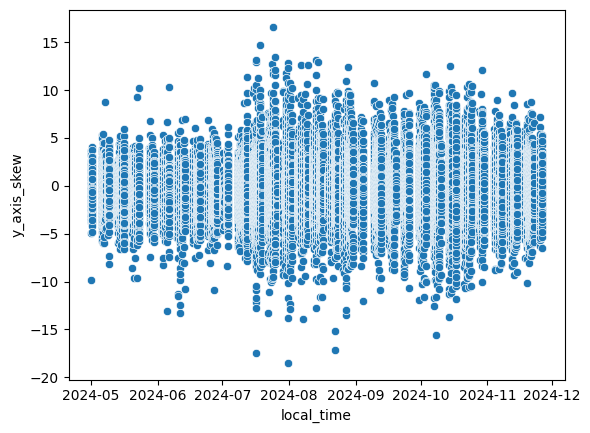

In [42]:
sns.scatterplot(data=df, x='local_time', y='y_axis_skew')

The 'y_axis_skew' feature on average is likely near zero, because it appears that a log skews negative as much as it skews positvely. The issue is not positive or negative skew in general though, so the skew will be converted to an absolute value.

In [43]:
#the axis skew can be absolute
df['y_axis_skew'] = abs(df['y_axis_skew'])

<AxesSubplot: xlabel='local_time', ylabel='y_axis_skew'>

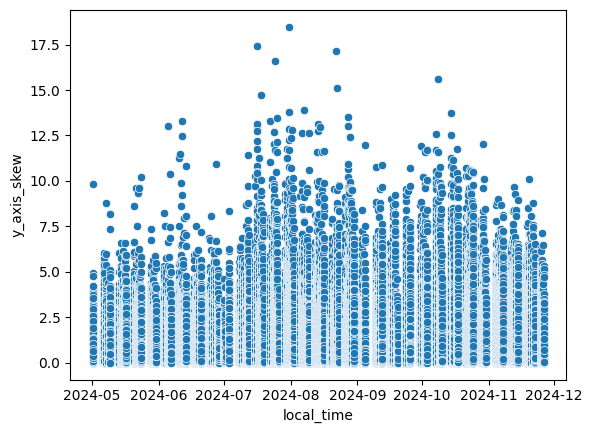

In [48]:
sns.scatterplot(data=df, x='local_time', y='y_axis_skew')

As can be seen in the above scatterplot, incidence of high skew cants at the secondary machine infeed has trended up over the last 3-4 months.

In [60]:
df_simple = df.drop(['sharpchain_rate', 
                             'delta_time_sec', 
                             'local_time', 
                             'estimated_in3', 
                             'boards_in_cant', 
                             'cant_height', 
                             'est_se_diam', 
                             'y_axis_offset', 
                             'chip_volume', 
                             'sawdust_volume', 
                             'feedspeed'], axis=1)
df_simple = df_simple.dropna(axis=0)


In [61]:
df_simple['taper'] = abs(df_simple['trail_end_dia'] - df_simple['lead_end_dia'])/df_simple.length

df_simple = df_simple.drop(['lead_end_dia'], axis = 1)
df_simple = df_simple.dropna(axis=0)
print(df_simple.info())
print(df_simple.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272006 entries, 0 to 272007
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trail_end_dia    272006 non-null  float64
 1   length           272006 non-null  int64  
 2   accumulated_dt   272006 non-null  float64
 3   num_sideboards   272006 non-null  int64  
 4   opto_chainspeed  272006 non-null  int64  
 5   cant_thickness   272006 non-null  float64
 6   solution_curve   272006 non-null  float64
 7   sweep            272006 non-null  float64
 8   y_axis_skew      272006 non-null  float64
 9   line_speed       272006 non-null  int64  
 10  gap              272006 non-null  float64
 11  hour             272006 non-null  int64  
 12  taper            272006 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 29.1 MB
None
       trail_end_dia         length  accumulated_dt  num_sideboards  \
count  272006.000000  272006.000000   272006.000000   272

<p>
   Data cleaning discussion:
    
An large part of the original uploaded data was extraneous date and ID columns. Additionally, there were several columns that were just a rehashing of the diameter or width of a log. After extraneous and repeated variables were dropped, a scatterplot of the dependant variable revealed that it was not absolute, so it was converted to an absolute value. Finally, NA values were dropped. By looking at the basic statistics of some of the features, it can be seen that some of the variables are likely not normally distributed at all, for example accumulated_dt is mostly zeros and gap is skewed to the right. Also, the dependant variable, "y_axis_skew" has some obvious skew, with most of the "y_axis_skew" being between 0.35 and 1.38 but with some instances of very high "y_axis_skew" occuring occasionally. Since I plan to use classification and grouping methods, I will normalize the data features in the next section, rather than dropping outliers.
<p/>

<p>The final dataset that is going to be used for this study contains 13 columns:
    
* train_end_dia: This is the diameter of the trailing end of the log in inches at the primary machine
* length: This is the length in inches of the log 
* accumulated_dt: This is the accumulated downtime for the primary machine at the time that the log was processed by it
* num_sideboards: This is the number of sideboards that were cut off of the log to make the cant at the primary machine. The primary machine will either cut 0 or 2 sideboards off of each log.
* opto_chainspeed: This is the feed speed in feet per minute at the primary machine
* cant_thickness: This is the thickness of the cant that is cut from a log after sideboards are cut off by the primary machine. 
* solution_curve: This is the amount of curve that the secondary machine will have to move to cut a swept log.
* sweep: This is the sweep of the log/cant. Sweep is calculated as the distance that the center of a curved log is from the endpoints of the log/cant
* y_axis_skew: This is the amount in inches that the cant has skewed before entering the secondary machine. A skewed log feeds into the machine at a slight angle and requires the secondary machine to continuously reposition along the length of the cant as it cuts the cant. This can cause quality issues downstream. 
* line_speed: The infeed speed of the secondary machine in feet per minute.
* gap: The set time of the secondary machine given in feet of feed.
* hour: The hour of the day. Saw sharpness declines throughout the shift and can cause downstream quality and infeed issues if they get dull enough. 
* taper: The taper of the log, calculated as (minimum diameter - maximum diameter) / length. In inches


The cleaned dataset contains information on 272,006 logs, gathered between May of 2024 and November of 2024 in a Washington State sawmill. </p>

<h4>Exploratory Data Analysis</h4>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272006 entries, 0 to 272007
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trail_end_dia    272006 non-null  float64
 1   length           272006 non-null  int64  
 2   accumulated_dt   272006 non-null  float64
 3   num_sideboards   272006 non-null  int64  
 4   opto_chainspeed  272006 non-null  int64  
 5   cant_thickness   272006 non-null  float64
 6   solution_curve   272006 non-null  float64
 7   sweep            272006 non-null  float64
 8   y_axis_skew      272006 non-null  float64
 9   line_speed       272006 non-null  int64  
 10  gap              272006 non-null  float64
 11  hour             272006 non-null  int64  
 12  taper            272006 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 29.1 MB


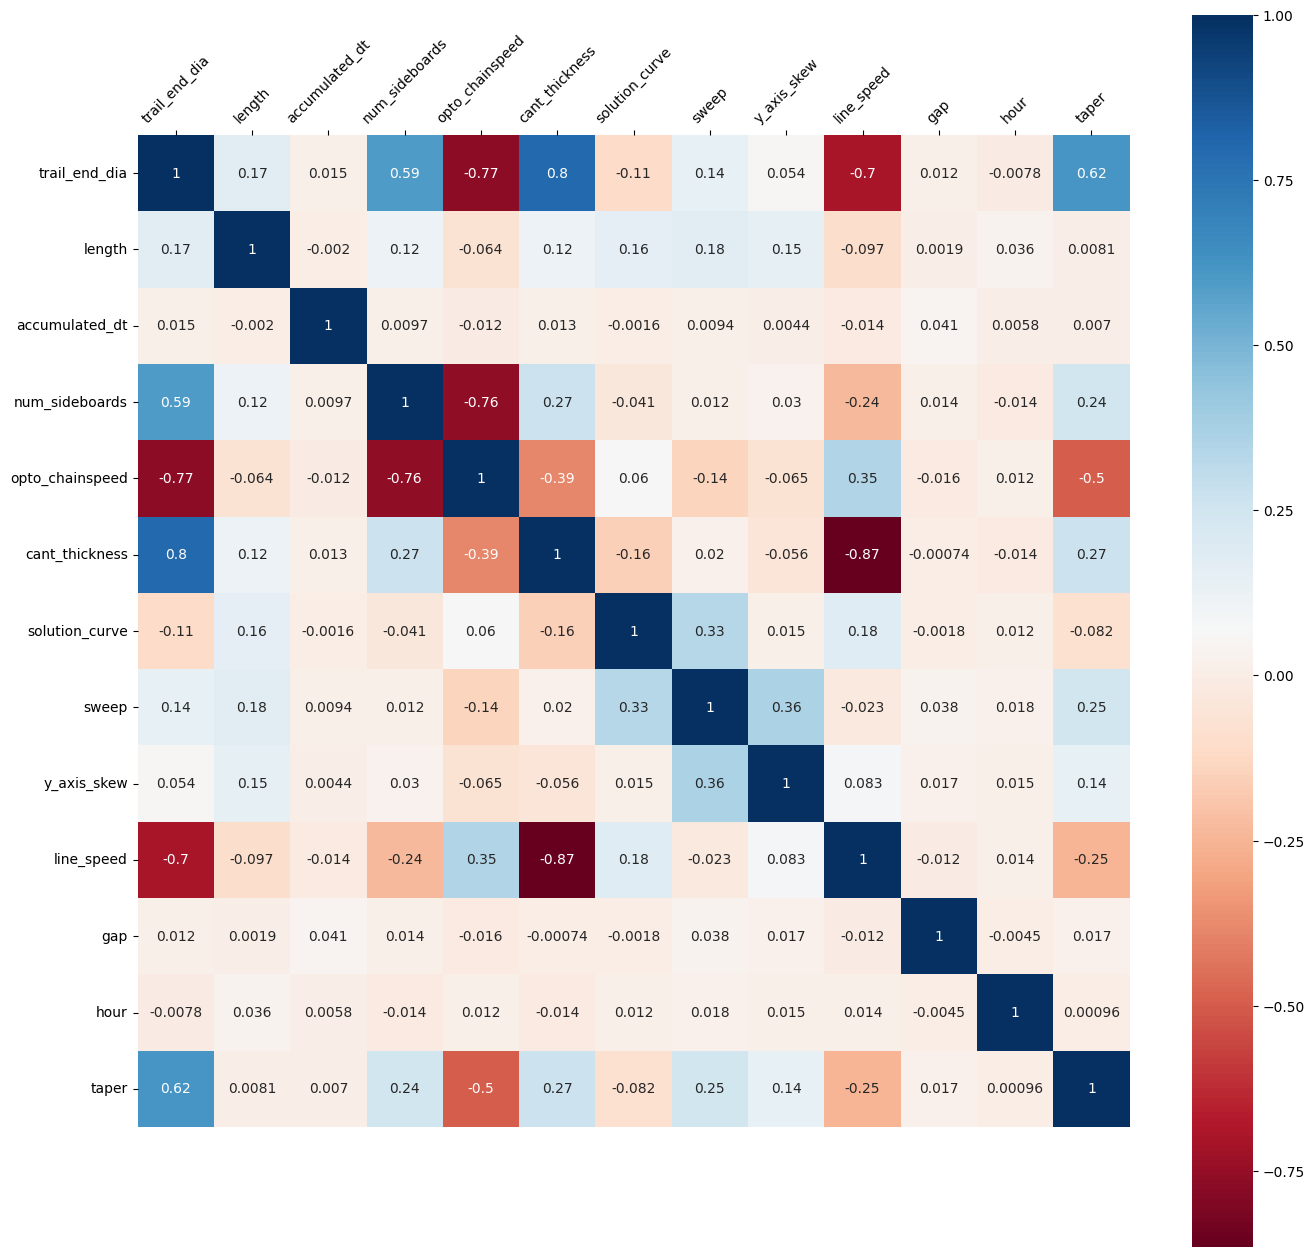

In [62]:
df_simple.info()
# sns.pairplot(df_simple.sample(100), diag_kind="kde")
plt.figure(figsize=(16,16))
hm = sns.heatmap(df_simple.corr(), annot=True, square=True, cmap="RdBu")
hm.set(xlabel="", ylabel="")
hm.set_xticklabels(hm.get_xticklabels(), rotation=45)
hm.xaxis.tick_top()

<p>I can see from the correlation heat map that some of the variables are heavily correlated and covariant. For example lead_end_dia and cant_thickness are likely pretty covariant, so I will remove one or both. However, I would like to create a derived column, "taper", using those two variables.<p/>
<p>The best correlations with skew are length, sweep, and taper, but no variable is heavily correlated<p/>

In [63]:
df_simple = df_simple.drop(['cant_thickness'], axis=1)

In [64]:
df_simple.describe()

,trail_end_dia,length,accumulated_dt,num_sideboards,opto_chainspeed,solution_curve,sweep,y_axis_skew,line_speed,gap,hour,taper
count,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000,272006.000000
mean,10.695325,190.170346,0.037567,0.409888,287.324228,0.258648,0.974435,1.030907,272.637412,19.433914,9.547021,0.010429
std,2.870555,23.428928,0.717975,0.807323,69.842878,0.329691,0.643576,1.014058,63.150987,57.199646,2.643440,0.006306
min,4.600000,97.000000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000002,115.000000,0.000000,5.000000,0.000000
25%,8.600000,195.000000,0.000000,0.000000,217.000000,0.000000,0.527621,0.351837,210.000000,13.083333,7.000000,0.006081
50%,10.100000,197.000000,0.000000,0.000000,310.000000,0.000000,0.800588,0.755712,290.000000,14.333333,9.000000,0.009129
75%,12.200000,199.000000,0.000000,0.000000,354.000000,0.499629,1.232788,1.378713,340.000000,17.166666,12.000000,0.013265
max,24.000000,241.000000,96.168000,2.000000,360.000000,1.549950,22.882000,18.477100,400.000000,14960.833000,16.000000,0.070946


<AxesSubplot: >

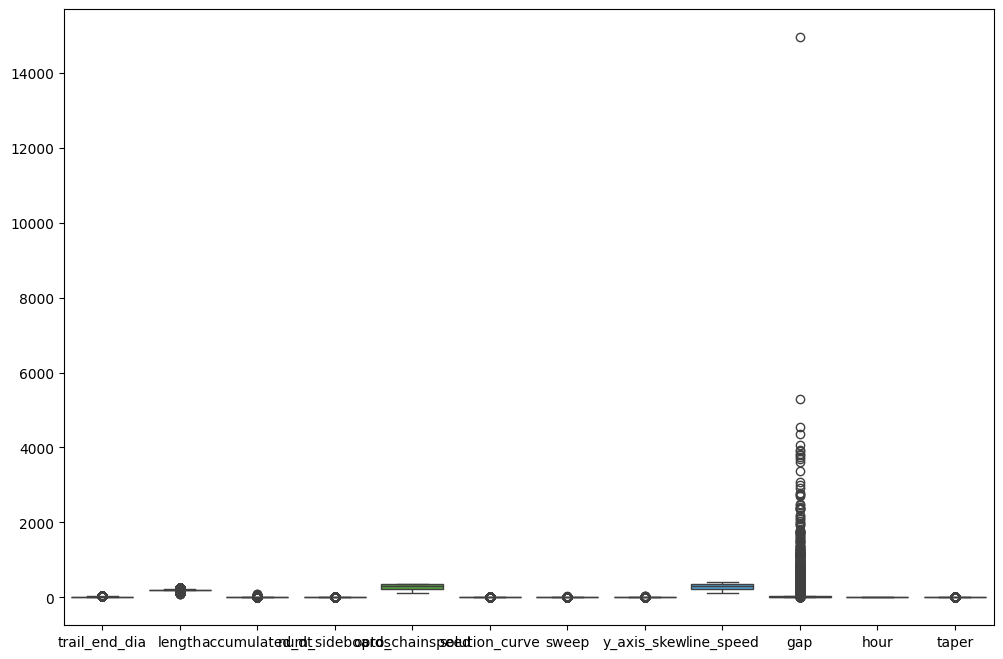

In [65]:
plt.figure(figsize=(12,8))


sns.boxplot(df_simple)


From the boxplot, it can be seen that there are some outliers, especially in the "gap" variable. The gap variable will have 1.5 times the interquartile range outliers removed. Then the data will be normalized by scaling it to the minimum and maximum of the column. 


In [66]:
from sklearn.preprocessing import MinMaxScaler

q1 = df_simple["gap"].quantile(0.25)
q3 = df_simple["gap"].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_simple["gap"] = df_simple[(df_simple["gap"]>=lower) & (df_simple["gap"]<=upper)]["gap"]

# q1 = df_simple["accumulated_dt"].quantile(0.25)
# q3 = df_simple["accumulated_dt"].quantile(0.75)
# iqr = q3 - q1
# upper = q3 + 1.5 * iqr
# lower = q1 - 1.5 * iqr
# df_simple["accumulated_dt"] = df_simple[(df_simple["accumulated_dt"]>=lower) & (df_simple["accumulated_dt"]<=upper)]["accumulated_dt"]


scaler = MinMaxScaler()
df_out = pd.DataFrame(scaler.fit_transform(df_simple))
df_out.columns = df_simple.columns
# for col in df_simple.columns:
#     # print(col)

    
df_out = df_out.dropna(axis = 0)
df_out.info()
df_out.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251150 entries, 0 to 272003
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trail_end_dia    251150 non-null  float64
 1   length           251150 non-null  float64
 2   accumulated_dt   251150 non-null  float64
 3   num_sideboards   251150 non-null  float64
 4   opto_chainspeed  251150 non-null  float64
 5   solution_curve   251150 non-null  float64
 6   sweep            251150 non-null  float64
 7   y_axis_skew      251150 non-null  float64
 8   line_speed       251150 non-null  float64
 9   gap              251150 non-null  float64
 10  hour             251150 non-null  float64
 11  taper            251150 non-null  float64
dtypes: float64(12)
memory usage: 24.9 MB


,trail_end_dia,length,accumulated_dt,num_sideboards,opto_chainspeed,solution_curve,sweep,y_axis_skew,line_speed,gap,hour,taper
count,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000,251150.000000
mean,0.311203,0.647015,0.000279,0.194684,0.705751,0.166737,0.041718,0.054958,0.555970,0.472370,0.413480,0.145160
std,0.145883,0.162796,0.006486,0.395958,0.287823,0.212050,0.026910,0.053995,0.219118,0.140203,0.240422,0.087353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.206186,0.680556,0.000000,0.000000,0.450000,0.000000,0.022824,0.018836,0.333333,0.356021,0.181818,0.085426
50%,0.278351,0.694444,0.000000,0.000000,0.804167,0.000000,0.034523,0.040384,0.614035,0.408377,0.363636,0.128139
75%,0.386598,0.708333,0.000000,0.000000,0.979167,0.321920,0.052856,0.073497,0.789474,0.575916,0.636364,0.184743
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.679407,1.000000,1.000000,1.000000,1.000000,0.848103


By looking at the boxplot of the scaled data set, we can see that the data is all in a much more comparable range.

<AxesSubplot: >

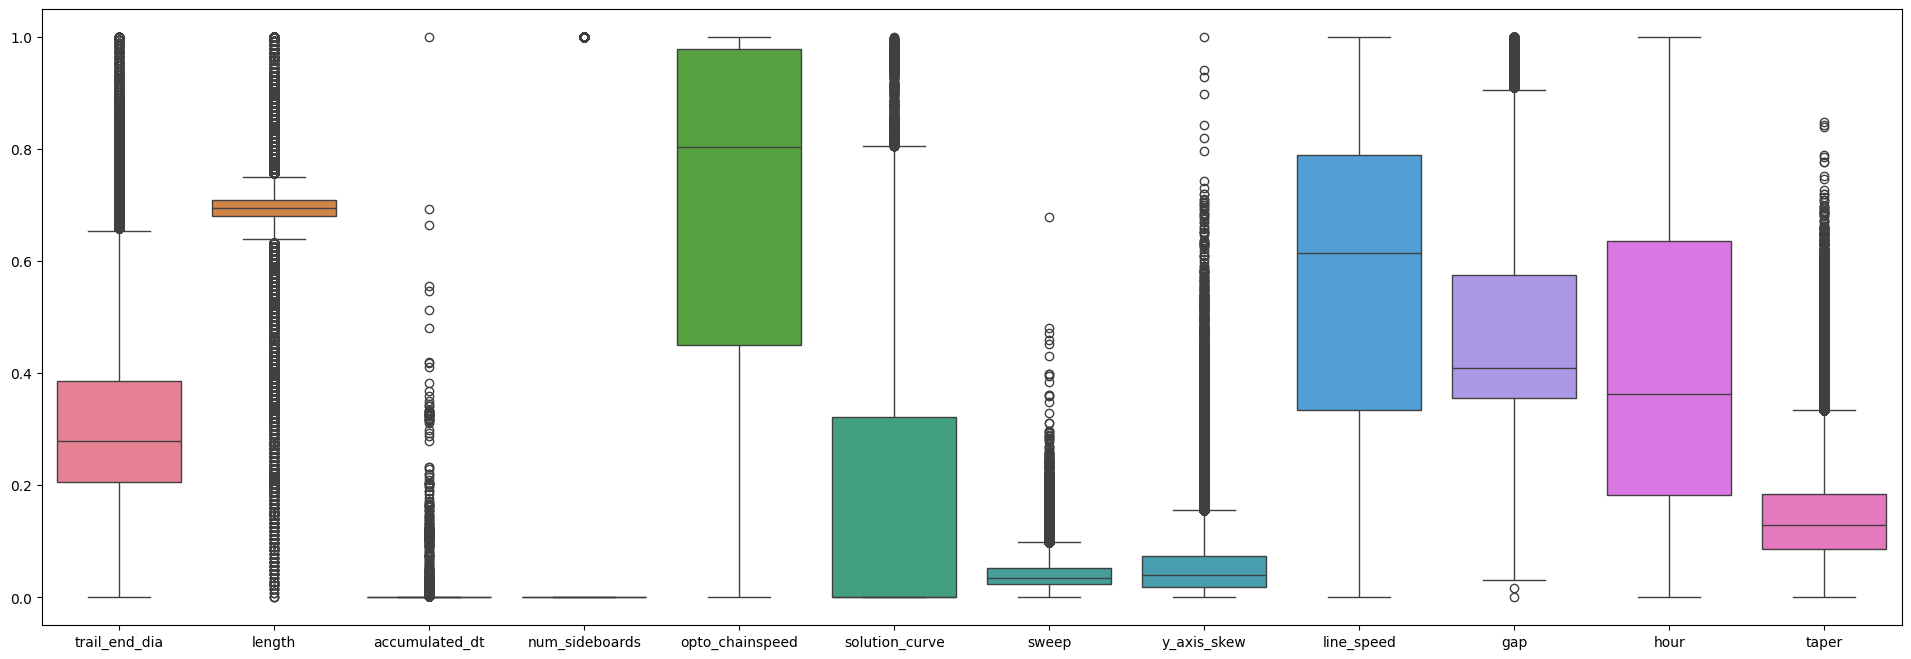

In [67]:
plt.figure(figsize=(24,8))
sns.boxplot(df_out)

I would like to try a multiple linear regression model to predict the y_axis_skew.

<AxesSubplot: xlabel='length', ylabel='y_axis_skew'>

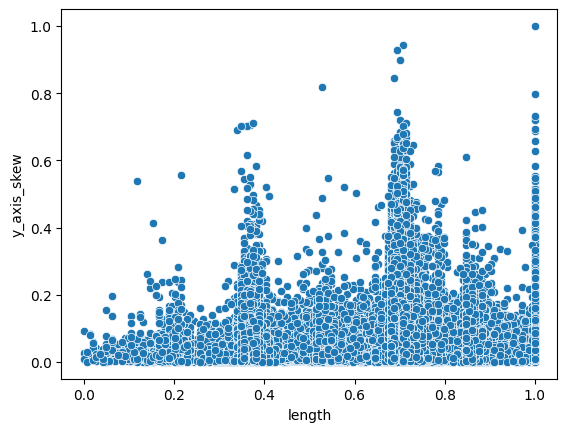

In [68]:
sns.scatterplot(df_out, x='length', y='y_axis_skew')

<AxesSubplot: xlabel='sweep', ylabel='y_axis_skew'>

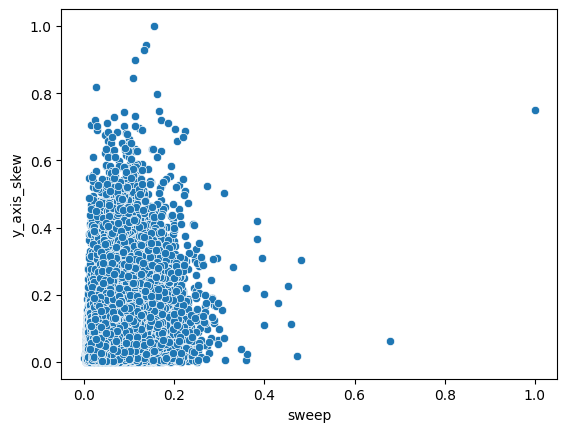

In [39]:
sns.scatterplot(df_out, x='sweep', y='y_axis_skew')

Length and sweep were two of the variables that were somewhat correlated with skew. As can be seen in the above scatterplots, length has a visible correlation with highly skewed logs, although there is quite a bit of variation in this relationship.

In [69]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

mod = smf.ols(formula=f'y_axis_skew ~  length + sweep + taper + num_sideboards + gap + line_speed', data=df_out).fit()
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:            y_axis_skew   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     7661.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        07:00:38   Log-Likelihood:             3.9781e+05
No. Observations:              251150   AIC:                        -7.956e+05
Df Residuals:                  251143   BIC:                        -7.955e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0225      0.001    -36.

As can be seen from the R-squared value, this model is pretty weak. By looking at the coefficients, we can see that "Sweep" causes the biggest impact in the "Skew" variable, with "length", "taper", and "gap" also having some impact. Next, a decision tree model will be tested. A new binary column will be derived with 1 for high skew and 0 for low log skew. "gap" is unlikely to have much of an impact in the regression model, with a P>|t| value that is much greater than 0.05. 

In [70]:
df_tree = df_out
df_tree['high_skew'] = 1
df_tree['high_skew'] = df_tree['high_skew'].where(df_tree['y_axis_skew'] > .04, 0)
df_tree = df_tree.drop(['y_axis_skew'], axis = 1)

<AxesSubplot: xlabel='taper', ylabel='sweep'>

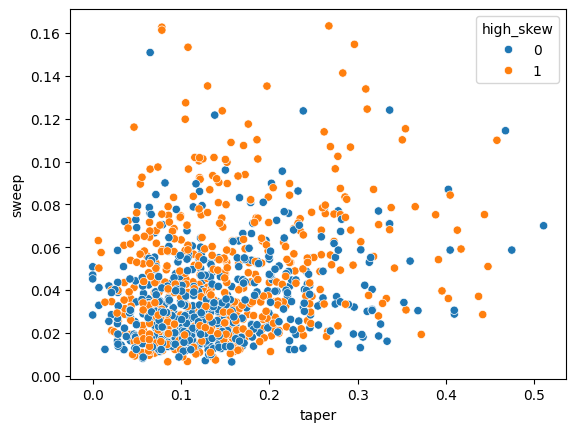

In [72]:
#sns.scatterplot(data=df_tree.sample(1000), x="taper", y="sweep", hue='high_skew')
sns.scatterplot(data=df_tree.sample(1000), x="taper", y="sweep", hue='high_skew')

<p>Although there is quite a bit of class mixing, it does appear that high skew logs are often highly tapered and/or highly swept (curved), with very straight logs often never skewing. There are many cases of low skew and low sweep logs skewing heavily however, indicating that there is potentially some other unseen factor that leads to skewed cants at the secondary machine. </p>
<p>
Exploratory data analysis on this dataset has revealed quite a lot of variation and exceptions, which make the creation of an accurate regression model with the given data difficult. Some important factors that might lead to highly skewed logs have potentially revealed themselves though. Log sweep, taper, and length all seem to have some impact, however slight, on how much a log/cant will skew on the infeed. It can also be seen that skew vs. sweep and taper relation is very mixed, so classification based on just those two features may be flawed. 
</p>

<h4>Models </h4>
Here, we will split the data into training and testing sets. 

In [73]:
from sklearn.model_selection import train_test_split
df_tree = df_tree.dropna(axis=0)
y = df_tree['high_skew']
X = df_tree.drop(['high_skew'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

accuracy of tree model: 0.6080524052494374
precision of tree model: 0.6360235306259353
recall of tree model: 0.5391024799895027


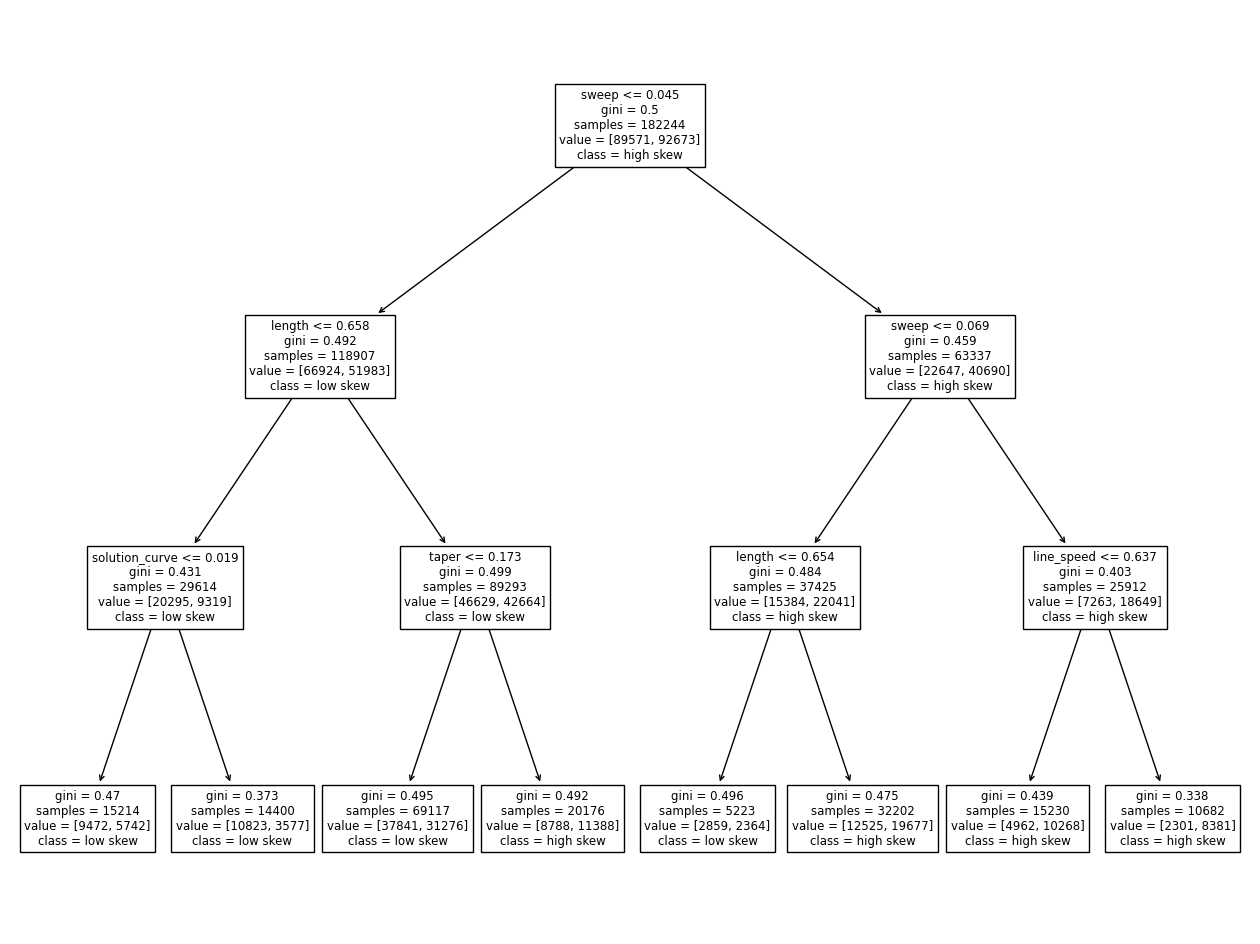

In [29]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
pre_score = precision_score(y_test, y_pred)
rec_score = recall_score(y_test, y_pred)
print(f'accuracy of tree model: {acc_score}')
print(f'precision of tree model: {pre_score}')
print(f'recall of tree model: {rec_score}')
plt.figure(figsize=(16,12))
tr_fig = tree.plot_tree(clf, feature_names=X_train.columns, class_names = ['low skew', 'high skew'])

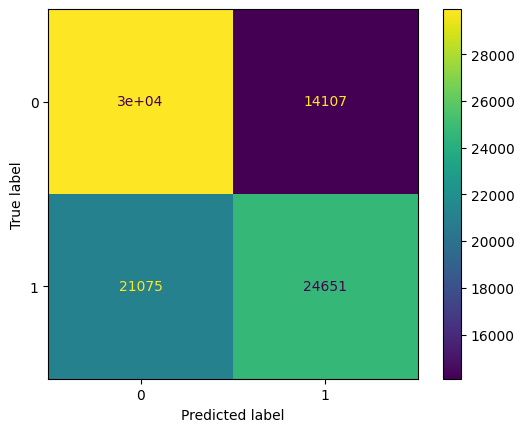

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
con_mat = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp1.plot()
plt.show()

As can be seen from the confusion matrix, the decision tree model is somewhat reasonable at predicting when a log/cant will have low skew, but not excellent and definitely not great at predicting hight skew cants. What is interesting is the features that the tree split on: 'length', 'sweep', 'taper', and 'line_speed'. Although 'solution_curve' also causes a split, in the mill, this feature occurs after the secondary machine infeed so it is more likely that a skewed cant causes a higher solution curve rather than the other way around.

accuracy of RF model: 0.6114502895752896
precision of RF model: 0.6288682221134497
recall of RF model: 0.5548331374007341


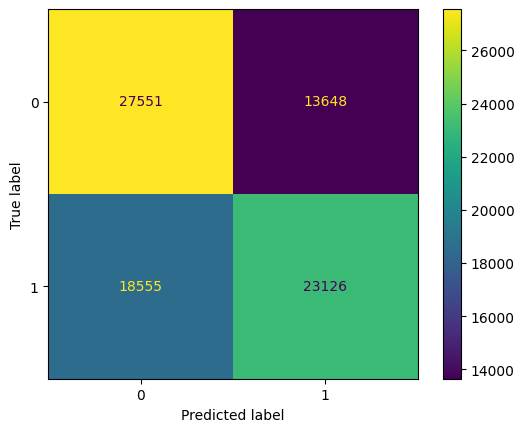

In [76]:
from sklearn.ensemble import RandomForestClassifier
# Xsingle = X_train['taper'].to_numpy().reshape(-1,1)
# Xsingle_t = X_test['taper'].to_numpy().reshape(-1,1)

RFModel = RandomForestClassifier(max_depth = 3, random_state=0)
RFModel.fit(X_train, y_train)
yHat = RFModel.predict(X_test)

acc_score = accuracy_score(y_test, yHat)
pre_score = precision_score(y_test, yHat)
rec_score = recall_score(y_test, yHat)
print(f'accuracy of RF model: {acc_score}')
print(f'precision of RF model: {pre_score}')
print(f'recall of RF model: {rec_score}')

con_mat = confusion_matrix(y_test, yHat)
disp2 = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp2.plot()
plt.show()

The random forest model is slightly improved from the simple decision tree. We will try a grid search on an SVM model next. The SVM on the original data set, with 200,000 plus rows is very slow, so we will sample 10,000-20,000 rows to train and test the SVM model. 

In [33]:
df_sampled = df_tree.sample(10000)
y = df_sampled['high_skew']
X = df_sampled.drop(['high_skew'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.describe()

,trail_end_dia,length,accumulated_dt,num_sideboards,opto_chainspeed,solution_curve,sweep,line_speed,gap,hour,taper
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,0.333543,0.789265,0.000382,0.200149,0.800239,0.165376,0.042896,0.552805,0.001278,0.407883,0.146726
std,0.144442,0.096425,0.006346,0.400142,0.192791,0.213282,0.028009,0.221815,0.002313,0.238625,0.088910
min,0.050000,0.414938,0.000000,0.000000,0.333333,0.000000,0.005762,0.052632,0.000401,0.000000,0.000000
25%,0.225000,0.809129,0.000000,0.000000,0.624306,0.000000,0.022926,0.333333,0.000875,0.181818,0.085426
50%,0.300000,0.817427,0.000000,0.000000,0.861111,0.000000,0.035308,0.614035,0.000952,0.363636,0.128789
75%,0.405000,0.825726,0.000000,0.000000,0.986111,0.317378,0.055106,0.789474,0.001136,0.636364,0.185089
max,1.000000,1.000000,0.332044,1.000000,1.000000,0.989509,0.289110,1.000000,0.074495,1.000000,0.637473


In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

nlsvm = SVC(kernel='rbf')

param = {'C':np.logspace(-5, 5,num=10, base=2), 'gamma':np.logspace(-5, 5,num=10, base=2)}
grid= GridSearchCV(nlsvm, param, cv=3)

grid.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([3.12500000e-02, 6.75037337e-02, 1.45816130e-01, 3.14980262e-01,
       6.80395000e-01, 1.46973449e+00, 3.17480210e+00, 6.85795186e+00,
       1.48139954e+01, 3.20000000e+01]),
                         'gamma': array([3.12500000e-02, 6.75037337e-02, 1.45816130e-01, 3.14980262e-01,
       6.80395000e-01, 1.46973449e+00, 3.17480210e+00, 6.85795186e+00,
       1.48139954e+01, 3.20000000e+01])})

In [35]:
yHat = grid.best_estimator_.predict(X_test)

acc_score = accuracy_score(y_test, yHat)
pre_score = precision_score(y_test, yHat)
rec_score = recall_score(y_test, yHat)
print(f'accuracy of SVM model: {acc_score}')
print(f'precision of SVM model: {pre_score}')
print(f'recall of SVM model: {rec_score}')



accuracy of SVM model: 0.6224242424242424
precision of SVM model: 0.6651982378854625
recall of SVM model: 0.5341981132075472


Performance of the SVM model is somewhat similart to the random forest model, with slightly lower recall, but somewhat higher accuracy and precision. I will try another SVM model, this time with only a subset of the original features.

In [36]:
X2 = X[['sweep', 'taper', 'length', 'line_speed']]
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.5, random_state=42)
X_train.describe()


,sweep,taper,length,line_speed
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.043503,0.147395,0.789722,0.551472
std,0.028674,0.089700,0.096655,0.221145
min,0.005762,0.000000,0.464730,0.052632
25%,0.023141,0.085714,0.809129,0.333333
50%,0.035711,0.129446,0.817427,0.614035
75%,0.055597,0.185089,0.825726,0.789474
max,0.289110,0.637473,1.000000,1.000000


In [37]:
grid.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([3.12500000e-02, 6.75037337e-02, 1.45816130e-01, 3.14980262e-01,
       6.80395000e-01, 1.46973449e+00, 3.17480210e+00, 6.85795186e+00,
       1.48139954e+01, 3.20000000e+01]),
                         'gamma': array([3.12500000e-02, 6.75037337e-02, 1.45816130e-01, 3.14980262e-01,
       6.80395000e-01, 1.46973449e+00, 3.17480210e+00, 6.85795186e+00,
       1.48139954e+01, 3.20000000e+01])})

In [40]:
yHat = grid.best_estimator_.predict(X_test)

acc_score = accuracy_score(y_test, yHat)
pre_score = precision_score(y_test, yHat)
rec_score = recall_score(y_test, yHat)
print(f'accuracy of SVM model: {acc_score}')
print(f'precision of SVM model: {pre_score}')
print(f'recall of SVM model: {rec_score}')

accuracy of SVM model: 0.6146
precision of SVM model: 0.6307300509337861
recall of SVM model: 0.5843491938655132


The limited feature SVM model ends up being the best performing of the models for recall, and is somewhat similar in accuracy and precision to the previous models. As can be seen from the confusion matrix, the model does equally well at predicting low skewed and high skewed cants. 

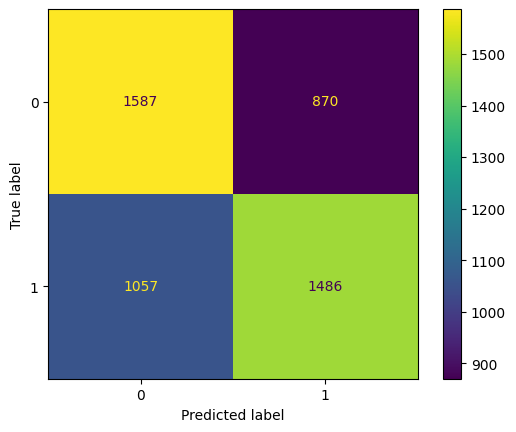

In [41]:

con_mat = confusion_matrix(y_test, yHat)
disp3 = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp3.plot()
plt.show()

<h4>Results and Analysis</h4>
<p>
    
    Decision Tree:
        Accuracy:  0.61
        Precision: 0.64
        Recall:    0.54
    
    Random Forest:
        Accuracy:  0.61
        Precision: 0.63 
        Recall:    0.55
    
    Support Vector Machine with Tuning:
        Accuracy:  0.61
        Precision: 0.63
        Recall:    0.58
</p>
 

Text(0.5, 1.0, 'Random Forest Feature Importance')

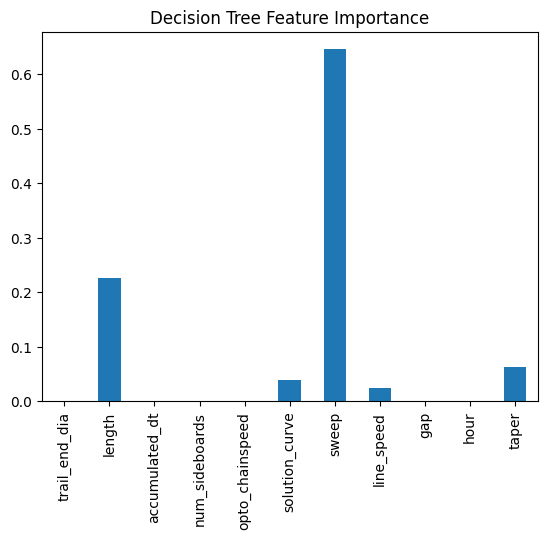

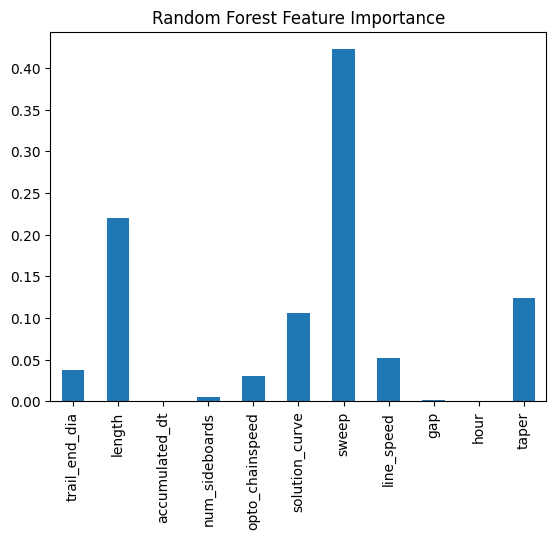

In [86]:
fig0, ax0 = plt.subplots()
DT_impF = clf.feature_importances_
DT_imp = pd.Series(DT_impF, index=X_test.columns)
DT_imp.plot.bar()
ax0.set_title("Decision Tree Feature Importance")


fig1, ax1 = plt.subplots()
RF_impF = RFModel.feature_importances_
RF_imp = pd.Series(RF_impF, index=X_test.columns)
RF_imp.plot.bar()
ax1.set_title("Random Forest Feature Importance")

<h4>Conclusion</h4>
<p>All of the models created in this study did perform somewhat reasonably and all performed similarly. The best performing model using recall was found to be the limited feature SVM model although any of the tree models may have performed as well or better given hyperparameter tuning with grid search. The final SVM model had an accuracy and precision score of 0.61 and 0.63 respectively, and with a recall score of 0.58, the model was able to find almost two-thirds of the high skew cants in the dataset. Despite the somewhat mediochre performance of the model, some potential insight was gained. For example, the primary dataset split used by the decision tree was the sweep (curve) of the log, so high skew logs were also highly swept logs. This certainly fits with observation in the actual sawmill, since highly skewed logs often bounce back after the machine has positioned them, and therefore are likely to be skewed when they feed into the machine. A seconday tree split occured using the length variable, which creates another potential avenue for quality and maintenance personnal in the mill to explore since it could indicate that a set of positioners in the machine at a certain length are malfunctioning or tuned badly. </p>
<p>In the future, it might serve to modify the dataset used in this study to contain more or different variables that might better predict the skew of the log. For example, quality feedback data on each log that is cut is available that would give some information on the straightness of the cut in a log and the error in primary saw position pre-positioning table. </p>